In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Time-decay модель.
Веса для модели расчитываются по формуле:

вес сессии = $2^{- d / s}$

где d - дней до покупки
s - количество сессий у пользователя

Почему такая формула? Давайте посмотрим на график функции

y = $2^{- x / s}$

Мы хотим увидеть, как меняется вес сессии в зависимости от 2 факторов:
- времени до сессии с покупкой
- количества сессий у пользователя

График выглядит так:

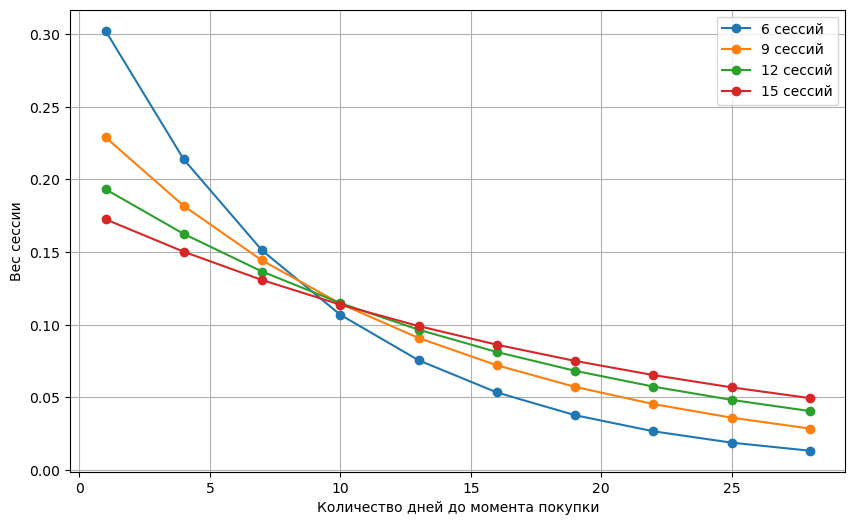

In [2]:
x = list(range(1, 31, 3))

plt.figure(figsize=(10, 6))

for s in range(6, 16, 3): 
    w = [2**(-d / s) for d in x]
    y = [weight / sum(w) for weight in w]  # нормируем, чтобы сумма весов была равна 1
    plt.plot(x, y, '-o', label=f'{s} сессий')

plt.legend(loc='best')
plt.xlabel('Количество дней до момента покупки')
plt.ylabel('Вес сессии')
plt.grid()
plt.show()

По графику можно сделать следующие выводы:
- график – убывающая функция: чем больше дней до покупки (горизонтальная ось), тем меньше вес у соответствующей сессии
- если пользователь приходил нечасто, то есть у него мало сессий, то веса очень сильно убывают с течением времени
- если пользователь часто к нам приходил, то веса убывают относительно медленно

Именно для того, чтобы функция убывала с ростом количества дней до покупки, перед количеством дней в формуле стоит знак "минус".
А для того, чтобы регулировать скорость убывания функции, мы используем количество сессий в качестве делителя.

Важный вывод – если пользователь приходит к нам редко, то для нас очень ценны сессии непосредственно перед покупкой. И наоборот, давние сессии для редкого гостя имеют мало ценности для бизнеса. 

In [3]:
session_data = pd.read_csv('data.csv', delimiter=';')

# изменение форматов данных для удобства
session_data['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in session_data['date']]
session_data[['cost', 'value']] = session_data[['cost', 'value']].astype(float)

# группировка и суммирования, чтобы объединить покупки с одинакового канала в один день
session_data = session_data.groupby(['userId', 'date', 'trafficSource'])['cost', 'value'].sum().reset_index()
session_data = session_data.sort_values(by=['userId', 'date'])
session_data.head()

C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\319236360.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  session_data = session_data.groupby(['userId', 'date', 'trafficSource'])['cost', 'value'].sum().reset_index()


,userId,date,trafficSource,cost,value
0,user_10,2020-01-05,telegram / posts,15.75,215.0
1,user_10000,2020-01-17,yandex / cpc,8.50,0.0
2,user_10000,2020-01-19,google / cpc,8.25,0.0
3,user_1002,2020-01-03,telegram / posts,15.75,0.0
4,user_1003,2020-01-08,google / cpc,8.25,0.0


In [4]:
# таблица только с датами покупок, нужна для time-decay модели

purchases_only = session_data[session_data['value'] > 0][['userId', 'date']]
purchases_only = purchases_only.groupby('userId')['date'].max().reset_index()
purchases_only.columns = ['userId', 'purchaseDate']

In [5]:
# расчет вспомогательных колонок

session_data['totalSessions'] = session_data.groupby('userId')['date'].transform(lambda x: x.count())
session_data['totalValue'] = session_data.groupby('userId')['value'].transform(lambda x: x.sum())
session_data['sessionNumber'] = session_data.groupby('userId').cumcount() + 1

session_data = session_data.merge(purchases_only, on='userId', how='left')

In [6]:
# расчет весов time-decay модели

session_data['daysToPurchase'] = [(x - y).days if x else 0
                                  for x, y in zip(session_data['purchaseDate'], session_data['date'])]

session_data['timeDecayWeight'] = [2**(-x / y)
                                   for x, y in zip(session_data['daysToPurchase'], session_data['totalSessions'])]

session_data['timeDecayWeight'] = session_data['timeDecayWeight'] / session_data.groupby('userId')['timeDecayWeight'].transform(lambda x: x.sum())


In [7]:
# расчет выручки на основе различных моделей атрибуции

session_data['lastTouchValue'] = session_data['value']
session_data['firstTouchValue'] = [x if y == 1 else 0
                                   for x, y in zip(session_data['totalValue'], session_data['sessionNumber'])]
session_data['linearValue'] = session_data['totalValue'] / session_data['totalSessions']
session_data['timeDecayValue'] = session_data['totalValue'] * session_data['timeDecayWeight']

print(session_data[['lastTouchValue', 'firstTouchValue', 'linearValue', 'timeDecayValue']].sum())

lastTouchValue     131345.0
firstTouchValue    131345.0
linearValue        131345.0
timeDecayValue     131345.0
dtype: float64


In [8]:
# финальная таблица

totals = session_data.groupby('trafficSource')[['cost', 'lastTouchValue', 'firstTouchValue', 'linearValue',
                                                'timeDecayValue']].sum()

totals['lastTouchROI'] = 100*(round(totals['lastTouchValue'] / totals['cost'], 4))
totals['firstTouchROI'] = 100*(round(totals['firstTouchValue'] / totals['cost'], 4))
totals['linearROI'] = 100*(round(totals['linearValue'] / totals['cost'], 4))
totals['timeDecayROI'] = 100*(round(totals['timeDecayValue'] / totals['cost'], 4))

totals[['cost', 'lastTouchROI', 'firstTouchROI', 'linearROI', 'timeDecayROI']]

,cost,lastTouchROI,firstTouchROI,linearROI,timeDecayROI
trafficSource,,,,,
facebook / video,28208.00,119.59,136.65,123.62,121.08
google / cpc,25137.75,169.30,163.54,169.77,178.20
telegram / posts,35374.50,82.91,71.97,78.05,78.77
vk / display,4498.75,96.58,103.42,91.51,78.79
yandex / cpc,14025.00,152.42,153.83,157.36,149.64


## Моделирование оптимальных бюджетов

In [10]:
NEW_BUDGET = 1e6

In [11]:
new_totals = totals.copy()
new_totals['new_budget'] = NEW_BUDGET * new_totals['cost'] / new_totals['cost'].sum()
linearModel = new_totals[['new_budget', 'lastTouchROI', 'linearROI']]
linearModel.head()

,new_budget,lastTouchROI,linearROI
trafficSource,,,
facebook / video,263026.369774,119.59,123.62
google / cpc,234397.728544,169.30,169.77
telegram / posts,329850.621014,82.91,78.05
vk / display,41948.733729,96.58,91.51
yandex / cpc,130776.546940,152.42,157.36


In [12]:
linearModel = new_totals[['new_budget', 'lastTouchROI', 'linearROI']]

linearModel['currentValue'] = round(linearModel['new_budget'] * linearModel['linearROI'] / 100, 2)
linearModel['delta'] =  linearModel['linearROI'] - linearModel['lastTouchROI']
linearModel['optimalSpend'] = round(linearModel['new_budget'] * linearModel['delta'] / 100 + linearModel['new_budget'], 2)
linearModel['optimalValue'] = round(linearModel['currentValue'] * linearModel['delta'] / 100 + linearModel['currentValue'], 2)

linearModel['profit'] = linearModel['optimalValue'] - linearModel['currentValue']

print(f'Суммарный профит от линейной модели = {round(sum(linearModel["profit"]), 2)}')

linearModel

Суммарный профит от линейной модели = 10681.76


C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\3092933284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linearModel['currentValue'] = round(linearModel['new_budget'] * linearModel['linearROI'] / 100, 2)
C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\3092933284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linearModel['delta'] =  linearModel['linearROI'] - linearModel['lastTouchROI']
C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\3092933284.py:5: SettingWithCopyWarning: 
A value is trying t

,new_budget,lastTouchROI,linearROI,currentValue,delta,optimalSpend,optimalValue,profit
trafficSource,,,,,,,,
facebook / video,263026.369774,119.59,123.62,325153.20,4.03,273626.33,338256.87,13103.67
google / cpc,234397.728544,169.30,169.77,397937.02,0.47,235499.40,399807.32,1870.30
telegram / posts,329850.621014,82.91,78.05,257448.41,-4.86,313819.88,244936.42,-12511.99
vk / display,41948.733729,96.58,91.51,38387.29,-5.07,39821.93,36441.05,-1946.24
yandex / cpc,130776.546940,152.42,157.36,205789.97,4.94,137236.91,215955.99,10166.02


In [13]:
tdModel = new_totals[['new_budget', 'lastTouchROI', 'timeDecayROI']]

tdModel['currentValue'] = round(tdModel['new_budget'] * tdModel['timeDecayROI'] / 100, 2)
tdModel['delta'] =  tdModel['timeDecayROI'] - tdModel['lastTouchROI']
tdModel['optimalSpend'] = round(tdModel['new_budget'] * tdModel['delta'] / 100 + tdModel['new_budget'], 2)
tdModel['optimalValue'] = round(tdModel['currentValue'] * tdModel['delta'] / 100 + tdModel['currentValue'], 2)

tdModel['profit'] = tdModel['optimalValue'] - tdModel['currentValue']

print(f'Суммарный профит от time-decay модели = {round(sum(tdModel["profit"]), 2)}')

tdModel

Суммарный профит от time-decay модели = 19843.42


C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\3970246136.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdModel['currentValue'] = round(tdModel['new_budget'] * tdModel['timeDecayROI'] / 100, 2)
C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\3970246136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdModel['delta'] =  tdModel['timeDecayROI'] - tdModel['lastTouchROI']
C:\Users\fabr6\AppData\Local\Temp\ipykernel_7548\3970246136.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy

,new_budget,lastTouchROI,timeDecayROI,currentValue,delta,optimalSpend,optimalValue,profit
trafficSource,,,,,,,,
facebook / video,263026.369774,119.59,121.08,318472.33,1.49,266945.46,323217.57,4745.24
google / cpc,234397.728544,169.30,178.20,417696.75,8.90,255259.13,454871.76,37175.01
telegram / posts,329850.621014,82.91,78.77,259823.33,-4.14,316194.81,249066.64,-10756.69
vk / display,41948.733729,96.58,78.79,33051.41,-17.79,34486.05,27171.56,-5879.85
yandex / cpc,130776.546940,152.42,149.64,195694.02,-2.78,127140.96,190253.73,-5440.29


In [16]:
# 1. Получим прибыли от использования линейной модели: 10681.76
# 2. Получим прибыли от использования модели time-decay: 19843.42
# 3. Линейная модель будет приносить больше выручки, за счет каналов: facebook - 13103.67, yandex - 10166.02
#    А меньше прибыли за счет google - 1870.30. А такие каналы как telegram и vk быдут приносить убыток - 12511.99 и - 1946.24
#    соответственно.
# 4. Модель time-decay будет приносить больше выручки, за счет канала: google - 37175.0, а меньше прибыли за счет 
#    facebook - 4745.24. А такие каналы как telegram, vk и yandex быдут приносить убыток 10756.69, 5879.85 и 5440.29
#    соответственно.
# 5. Я считаю что линейная модель и модель time-decay показали такие разные результаты за счето того, 
#    что качественно изменились показатели дельта по таким каналам как google и vk 
#    Для канала google с 0.47пп для линейной модели на 8.9пп модель time-decay, а
#    для канала vk с -5.07пп для линейной модели на -17.79пп модель time-decay, а так как разница в доходах и расходах
#    по данным каналам составляет более 5раз не в пользу vk, то соответствено мы получаем большую прибыль 
#    от использования модели time-decay